## Install the dependencies

In [1]:
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install opencv-contrib-python
!pip install keras
!pip install hnswlib

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for hnswlib: filename=hnswlib-0.5.2-cp38-cp38-win_amd64.whl size=125001 sha256=33c1cd1d7be247ab96822b5fcaa7ddf9cb83aa816a3c62d44bb32a9c1ec915ba
  Stored in directory: c:\users\gengi\appdata\local\pip\cache\wheels\53\35\8d\37ecfb49a1336024b5a679ffc8ab8b6be1820d3141716b23db
Successfully built hnswlib

You should consider upgrading via the 'C:\Users\gengi\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [28]:
import cv2
import numpy as np
import json
import warnings
import hnswlib
from matplotlib import pyplot as plt
import time

warnings.filterwarnings("ignore", category=FutureWarning)

## Loading boxes for template

In [29]:
fObj = open(".\Templates\BirthCertificate.json")
template = json.load(fObj)
fields = template['Pages'][0]['Fields']
print(json.dumps(fields, indent=4, sort_keys=True))

[
    {
        "BoundingBox": {
            "height": 20,
            "width": 59,
            "x": 307,
            "y": 180
        },
        "DataType": "text",
        "FieldName": "CNSeries",
        "FieldType": "TextField",
        "Mappings": {}
    },
    {
        "BoundingBox": {
            "height": 21,
            "width": 153,
            "x": 387,
            "y": 178
        },
        "DataType": "text",
        "FieldName": "BirthCertificateNumber",
        "FieldType": "TextField",
        "Mappings": {}
    },
    {
        "BoundingBox": {
            "height": 49,
            "width": 276,
            "x": 454,
            "y": 225
        },
        "DataType": "cnp",
        "FieldName": "CNP",
        "FieldType": "TextField",
        "Mappings": {}
    },
    {
        "BoundingBox": {
            "height": 37,
            "width": 525,
            "x": 205,
            "y": 290
        },
        "DataType": "text",
        "FieldName": "LastName",
       

## Loading image template

In [30]:
templateImg = cv2.imread(".\Templates\\BirthCertificate.jpg", cv2.IMREAD_COLOR)
cv2.imshow("BirthCertificate", templateImg)
cv2.waitKey(0)
cv2.destroyAllWindows()


## Displaying of bounding boxes over the template image

In [31]:
for field in fields:
    if "BoundingBox" in field:
        x, y, w, h = (field["BoundingBox"]["x"], field["BoundingBox"]["y"], field["BoundingBox"]["width"], field["BoundingBox"]["height"])
        start_point = (x, y)
        end_point = (x + w, y + h)
        cv2.rectangle(templateImg, start_point, end_point, (0, 0, 255), 1)
    
cv2.imshow("BirthCertificate", templateImg)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Feature extraction and matching using SIFT extracter and Flann Matcher
##### img2 is the target image

In [32]:
img1 = cv2.imread(".\Templates\\BirthCertificate.jpg", 0)
# change with your image
img2 = cv2.imread(".\Test\\BirthCertificateTest1.jpg", 0)

MIN_MATCH_COUNT = 10
# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

t0 = time.time()

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

t1 = time.time() - t0
print("Time elapsed: ", t1) # CPU seconds elapsed (floating point)
        
print(len(matches))
print(len(good))

Time elapsed:  0.7840378284454346
12677
269


## Showing of matching points and their corresponding

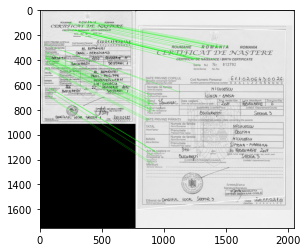

(<matplotlib.image.AxesImage at 0x213a559a400>, None)

In [33]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()

## Feature normalization

In [34]:
def rootSift(descriptors, eps= 1e-7):
    descriptors = np.abs(descriptors)
    sums_vec = cv2.reduce(descriptors, 1, cv2.REDUCE_SUM, cv2.CV_32FC1)
    
    #print(descriptors.shape)
    for row in range(0, descriptors.shape[0]):
        #offset = row * descriptors.cols
        for col in range(0, descriptors.shape[1]):
            descriptors[row][col] = np.sqrt(descriptors[row][col] / (sums_vec[row] + eps))
        
        cv2.normalize(descriptors[row], descriptors[row], 1.0, 0.0, cv2.NORM_L2)
    
    return descriptors

## Feature matching with HNSWLIB

In [41]:
img1 = cv2.imread(".\Templates\\BirthCertificate.jpg", 0)
# change with your image
img2 = cv2.imread(".\Test\\BirthCertificateTest1.jpg", 0)


MIN_MATCH_COUNT = 10
# Initiate SIFT detector
sift = cv2.SIFT_create(1024)
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

t0 = time.time()

des1 = rootSift(des1)
des2 = rootSift(des2)

num_elements, dim = des1.shape
ids = np.arange(num_elements)

p = hnswlib.Index(space = 'l2', dim = dim)
p.init_index(max_elements = num_elements, ef_construction = 100, M = 16)
p.set_ef(50)
p.set_num_threads(8)
p.add_items(des1, ids)

labels, distances = p.knn_query(des2, k = 3)
good = []

for i in range(0, len(labels)):
    q = []
    for k in range(0, len(labels[i])):
        q.append(distances[i][k])

    q.sort(reverse = True)
    
    c = None
    
    for k in range(0, len(labels[i])):
        if q[0] == distances[i][k]:
            c = k
    
    if c != None:
        angle = np.abs(kp2[i].angle - kp1[labels[i][c]].angle)
        if angle < 10 and np.abs(q[0]) < 0.2:
            good.append(cv2.DMatch(labels[i][c], i, q[0]))

t1 = time.time() - t0
print("Time elapsed: ", t1) # CPU seconds elapsed (floating point)

print(len(good))

Time elapsed:  1.2160253524780273
103


## Compute points

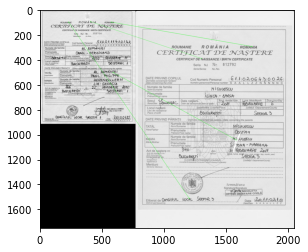

(<matplotlib.image.AxesImage at 0x213a3e3a130>, None)

In [42]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()

## Perspective Transform of the target image

In [43]:
H_inv, status  = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC,5.0)
im_dst = cv2.warpPerspective(img2, H_inv, (w,h))
#plt.imshow(im_dst, 'gray'),plt.show()

for field in fields:
    if "BoundingBox" in field:
        x, y, w, h = (field["BoundingBox"]["x"], field["BoundingBox"]["y"], field["BoundingBox"]["width"], field["BoundingBox"]["height"])
        start_point = (x, y)
        end_point = (x + w, y + h)
        cv2.rectangle(im_dst, start_point, end_point, (0, 0, 255), 1)

cv2.imshow("BirthCertificate", im_dst)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Cropping of the "CNP" field for character recognition

In [60]:
cnp = fields[2]
bbox = cnp['BoundingBox']
x = bbox['x']
y = bbox['y']
w = bbox['width']
h = bbox['height']

cnp_img = im_dst[y:y+h, x:x+w]
cv2.imshow("CNP", cnp_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Building of the numbers classifier
#### Ensemble training using multiple CNN models

In [61]:
from keras.datasets import mnist
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
import itertools
import math
from sklearn.model_selection import train_test_split, KFold
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop, Adagrad

(train_X, train_y), (test_X, test_y) = mnist.load_data()

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


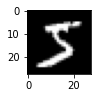

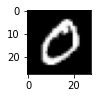

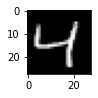

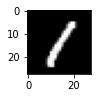

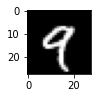

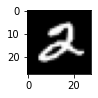

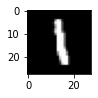

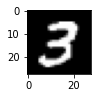

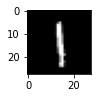

In [19]:
from matplotlib import pyplot
for i in range(9):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))
    pyplot.show()

In [20]:
train_X = train_X / 255.0
test_X = test_X / 255.0

train_X = train_X.reshape(-1,28,28,1)
test_X = test_X.reshape(-1,28,28,1)

In [21]:
train_y = to_categorical(train_y, num_classes = 10)
test_y = to_categorical(test_y, num_classes = 10)

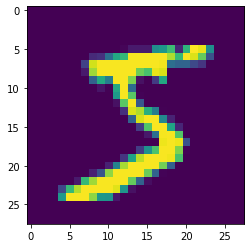

In [22]:
g = plt.imshow(train_X[0][:,:,0])

In [23]:
from keras.optimizers import RMSprop, Adam
from keras.layers import DepthwiseConv2D, Reshape, Activation

nets = 10
model = [0] *nets


for j in range(nets):
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(10, activation='softmax'))

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
    
print('All Models Defined')

All Models Defined


In [24]:
# LR Reduction Callback
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=0, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [25]:
# train for 20 epochs
history = [0] * nets
epochs = 20

datagen = ImageDataGenerator(
    rotation_range=13,
    zoom_range=0.11,
    width_shift_range=0.1,
    height_shift_range=0.1
)

datagen.fit(train_X)

for j in range(nets):  
    print(f'Individual Net: {j+1}')   
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(train_X, train_y, test_size = 0.1)
    history[j] = model[j].fit_generator(datagen.flow(X_train2,Y_train2, batch_size=64),
        epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
        validation_data = (X_val2,Y_val2), callbacks=[learning_rate_reduction], verbose=0)
    
    print("CNN Model {0:d}: Epochs={1:d}, Training accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

Individual Net: 1
Instructions for updating:
Please use Model.fit, which supports generators.
CNN Model 1: Epochs=20, Training accuracy=0.99281, Validation accuracy=0.99650
Individual Net: 2
CNN Model 2: Epochs=20, Training accuracy=0.99060, Validation accuracy=0.99550
Individual Net: 3
CNN Model 3: Epochs=20, Training accuracy=0.99305, Validation accuracy=0.99533
Individual Net: 4
CNN Model 4: Epochs=20, Training accuracy=0.99197, Validation accuracy=0.99550
Individual Net: 5
CNN Model 5: Epochs=20, Training accuracy=0.99407, Validation accuracy=0.99733
Individual Net: 6
CNN Model 6: Epochs=20, Training accuracy=0.99168, Validation accuracy=0.99567
Individual Net: 7
CNN Model 7: Epochs=20, Training accuracy=0.99262, Validation accuracy=0.99483
Individual Net: 8
CNN Model 8: Epochs=20, Training accuracy=0.99273, Validation accuracy=0.99617
Individual Net: 9
CNN Model 9: Epochs=20, Training accuracy=0.99386, Validation accuracy=0.99600
Individual Net: 10
CNN Model 10: Epochs=20, Trainin

In [27]:
#Result
results = np.zeros( (test_X.shape[0],10) ) 
for j in range(nets):
    results = results + model[j].predict(test_X)
    
results = np.argmax(results,axis = 1)

Text(0.5, 1.0, '7')

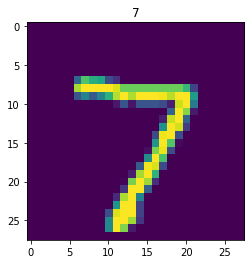

In [28]:
#Test on result
plt.imshow(test_X[0][:,:,0])
plt.title(results[0])

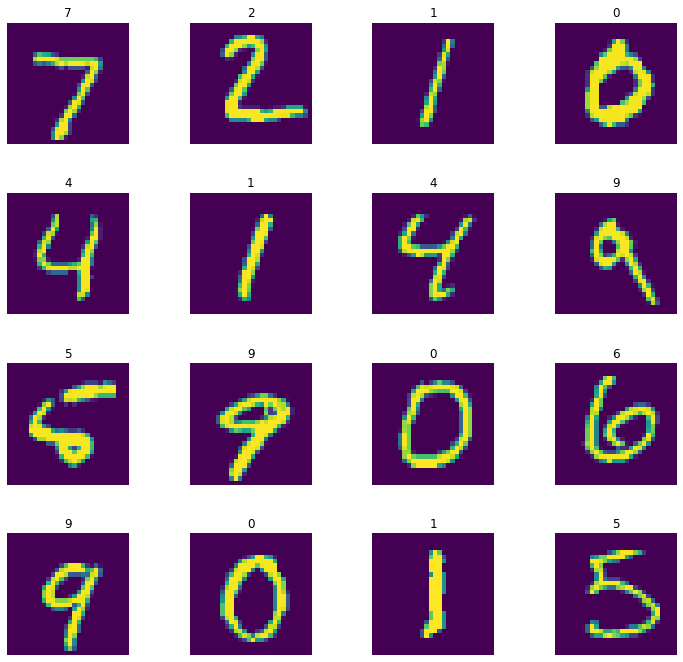

In [29]:
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(test_X[i].reshape(28,28))
    axes[i].set_title(results[i])
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

## Saving the models

In [30]:
model[0].summary()
for j in range(nets): 
    model[j].save("digits_model" + str(j) + ".h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0

## Loading the models for inference

In [31]:
from keras.models import load_model

nets = 10
model = [0] *nets

for j in range(nets):
    model[j] = load_model("digits_model" + str(j) + ".h5")

## Binarization

In [41]:
img_gray = cnp_img.copy()

# apply binary thresholding
ret, thresh = cv2.threshold(img_gray, 180, 255, cv2.THRESH_BINARY)

image_final = cv2.bitwise_and(img_gray, img_gray, mask=thresh)

ret, new_img =  cv2.threshold(image_final, 180, 255, cv2.THRESH_BINARY_INV)

#kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3)) 
#dilated = cv2.dilate(new_img, kernel, iterations=9)

# # visualize the binary image
cv2.imshow('thresh', new_img)
cv2.waitKey(0)
# cv2.imwrite('image_thres1.jpg', thresh)
cv2.destroyAllWindows()

## Contours detection of characters and sorting from left to right

In [42]:
# # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours, hierarchy = cv2.findContours(image=new_img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
                                     
# # draw contours on the original image
image_copy = cnp_img.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)
               
# # see the results
cv2.imshow('None approximation', image_copy)
cv2.waitKey(0)
# cv2.imwrite('contours_none_image1.jpg', image_copy)
cv2.destroyAllWindows()

In [43]:
import sys

epsilon = sys.float_info.epsilon
cnts = []
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    ratio = w / (h + epsilon)
    area = cv2.contourArea(cnt)
    if ratio >= 0.2 and ratio <= 1.2 and area > 30 and area < 150:
            cnts.append(cnt)
    


mask = np.ones(image_copy.shape, dtype="uint8") * 255
cv2.drawContours(mask, cnts, -1, (0,0,0),-1)
cv2.imshow("Contours", mask)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [44]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [45]:
cnts, bbx = sort_contours(cnts)

distances = []
prev = None
first = True

for cnt in cnts:
    if first == True:
        prev = cnt
        first = False
    
    else:
        x,y,_,_ = cv2.boundingRect(cnt)
        xp,yp,_,_ = cv2.boundingRect(prev)
        distances.append(x - xp)
    
    prev = cnt

## Dropping outlier contours

In [46]:
standard_deviation = np.std(distances)
mean_average = np.mean(distances)

In [50]:
from math import ceil, floor

def accepted(value, standard_deviation, mean_average):
    a = value < ceil(mean_average) + 2 * ceil(standard_deviation)
    b = value < floor(mean_average) - 2 * 2 * ceil(standard_deviation)
    return a and b
    

filtered_cnts = []

if len(cnts) <= 13:
    filtered_cnts = cnts

if len(cnts) > 13:
    left_hand = []
    right_hand = []
    
    for i in range(0, (len(distances) + 1) // 2):
        if accepted(distances[i], standard_deviation, mean_average):
            left_hand.append(cnt[i])
    
    for i in range(len(distances), (len(distances) + 1) // 2, -1):
        if accepted(distances[i], standard_deviation, mean_average):
            right_hand.append(cnt[i+1])

    filtered_cnts = left_hand + reverse(right_hand)


## Turning a character in input for classification

In [51]:
numbers = []
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])


for cnt in filtered_cnts:
    x, y, w, h = cv2.boundingRect(cnt)
    number = cnp_img[y-2:y+h+2, x-2:x+w+2]
    invert = cv2.bitwise_not(number)
    resized = cv2.resize(invert, (28, 28), interpolation=cv2.INTER_CUBIC)
    sharpened = cv2.filter2D(resized, -1, kernel_sharpening)
    numbers.append(sharpened)
    cv2.imshow("CNP", sharpened)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## Inference

In [52]:
for number in numbers:
    number = number.reshape(-1, 28, 28, 1)
    number = number / 255.0
    result = np.zeros( (number.shape[0],10) ) 
    for j in range(nets):
        result = result + model[j].predict(number)
    print(result)
    result = np.argmax(result,axis = 1)
    print(result[0])
    
    #plt.imshow(number[0][:,:,0])
    #plt.title(result[0])

[[2.11421517e-02 1.70057718e-04 8.33511462e-01 9.02061704e-03
  7.70573998e-03 7.80743560e-02 4.05074303e+00 5.00675911e-04
  4.29201388e+00 7.07118078e-01]]
8
[[7.51336587e-03 1.27125602e-02 5.06844060e-02 2.52072092e-02
  6.17825109e+00 8.42446675e-03 4.23075391e-03 4.39692330e-02
  3.61671048e+00 5.22964663e-02]]
4
[[2.12452436e-02 1.51603010e-02 6.72066618e-01 5.96716683e-02
  1.58342011e+00 5.05988454e-03 3.78932102e-03 7.28428168e-02
  7.46001178e+00 1.06732063e-01]]
8
[[9.99991000e+00 3.08834811e-08 7.11537496e-06 1.24246949e-07
  1.57880635e-07 3.26983352e-07 4.20799541e-05 1.36901639e-07
  1.40494894e-05 2.62410951e-05]]
0
[[8.27456220e-03 2.83794503e-05 9.35107464e+00 2.93968357e-04
  6.61774993e-02 2.62061955e-04 4.10125716e-04 5.77303821e-03
  5.66227151e-01 1.47834564e-03]]
2
[[5.35415445e+00 1.78475021e-05 4.90460554e-02 1.27594281e-04
  2.40698115e-02 1.29074095e-04 5.19583687e-03 2.06152235e-04
  1.49894582e-02 4.55206375e+00]]
0
[[1.38461686e-01 1.77625909e-06 2.418472